<a href="https://colab.research.google.com/github/JoDeMiro/ImageProcessing/blob/main/07_Image_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Fourier Transformation

https://web.cs.elte.hu/blobs/diplomamunkak/bsc_alkmat/2015/havasreti_kristof.pdf



https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

https://towardsdatascience.com/fast-fourier-transform-937926e591cb

[0.96231015 0.57589031 0.23198419 ... 0.17661717 0.63604208 0.09372941]


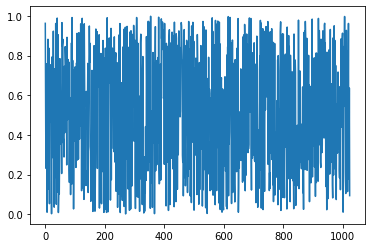

True

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

x = np.random.random(1024)
print(x)
plt.plot(x)
plt.show()

# Ugyan azt az eredményt adja-e a saját és a np.fft függvény? (Igen)
np.allclose(dft(x), np.fft.fft(x))

In [9]:
%timeit dft(x)
%timeit np.fft.fft(x)

10 loops, best of 5: 124 ms per loop
The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 16.1 µs per loop


Az Fast Fourier Transformáció a Discrete Fourier Transformációt alkalmazza kisebb adatokon (páros páratlan indexelés) és a kapott eredményeket kombinálja.


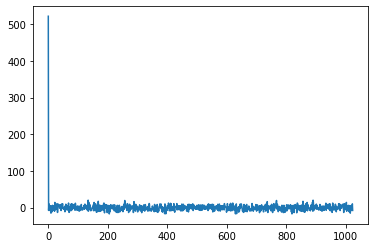

In [10]:
def fft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N % 2 > 0:
        raise ValueError("must be a power of 2")
    elif N <= 2:
        return dft(x)
    else:
        X_even = fft(x[::2])
        X_odd = fft(x[1::2])
        terms = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + terms[:int(N/2)] * X_odd,
                               X_even + terms[int(N/2):] * X_odd])
        

x = np.random.random(1024)
np.allclose(fft(x), np.fft.fft(x))

plt.plot(fft(x))
plt.show()

Habár az FFT sokkar gyorsabb mint a discrete változata még mindíg lassabb mint a numpy implementáció, mert az mátrix műveleteket használ a Fourier Transformáció kiszámításához.

In [11]:
%timeit dft(x)
%timeit fft(x)
%timeit np.fft.fft(x)

10 loops, best of 5: 122 ms per loop
100 loops, best of 5: 15.8 ms per loop
The slowest run took 58.16 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16 µs per loop


In [18]:
# Rekurzió helyett most vektor műveletekkel számoljuk ki ugyan ezt

def fft_v(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if np.log2(N) % 1 > 0:
        raise ValueError("must be a power of 2")
        
    N_min = min(N, 2)
    
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    while X.shape[0] < N:
        X_even = X[:, :int(X.shape[1] / 2)]
        X_odd = X[:, int(X.shape[1] / 2):]
        terms = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + terms * X_odd,
                       X_even - terms * X_odd])
    return X.ravel()


x = np.random.random(1024)
np.allclose(fft_v(x), np.fft.fft(x))


True

In [19]:
%timeit fft(x)
%timeit fft_v(x)
%timeit np.fft.fft(x)

100 loops, best of 5: 15.7 ms per loop
1000 loops, best of 5: 373 µs per loop
The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.1 µs per loop


https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.03-Fast-Fourier-Transform.html

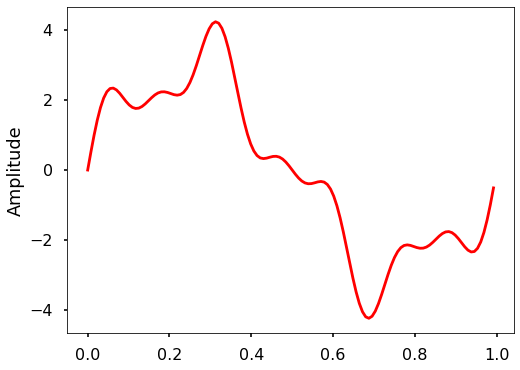

In [22]:
# Az FFT nél az a lényeg, hogy valahogy kettéosztja az adatokat és a kisebb elemeken számolja a DFT-t
# és ezt valahogy rekurzívan teszi.

# Fontos viszont, hogy az adatok hossza 2 hatványa legyen (512, 1024, 2048, stb)
# ha nem az akkor 0-val szokták kitölteni a hiányzó részeket

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

def FFT(x):
    """
    A recursive implementation of 
    the 1D Cooley-Tukey FFT, the 
    input should have a length of 
    power of 2. 
    """
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = \
          np.exp(-2j*np.pi*np.arange(N)/ N)
        
        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X

# --------------------------------------------

# sampling rate
sr = 128
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')
plt.show()

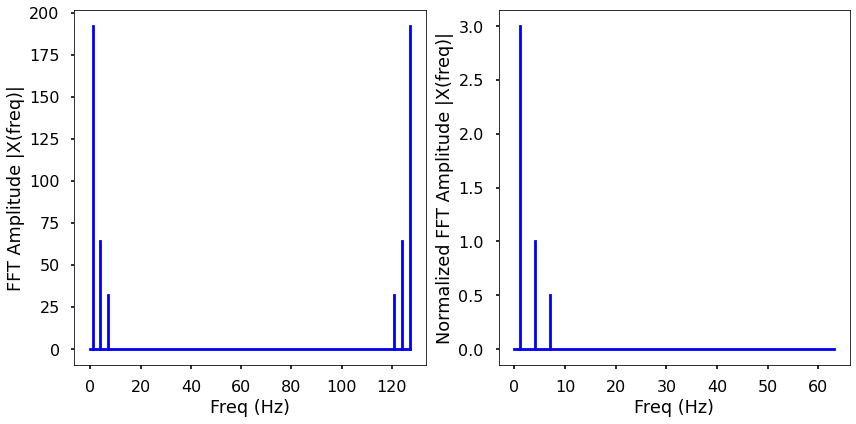

In [24]:
# Na most kiszámojuk a fenti függvény Fourirer Transzformáltját.

# Valahogy annak kell kijönnie, hogy 1, 4, 7 (merthogy így állítottuk
# elő a fenti függvényt)

X=FFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Normalized FFT Amplitude |X(freq)|')
plt.tight_layout()
plt.show()

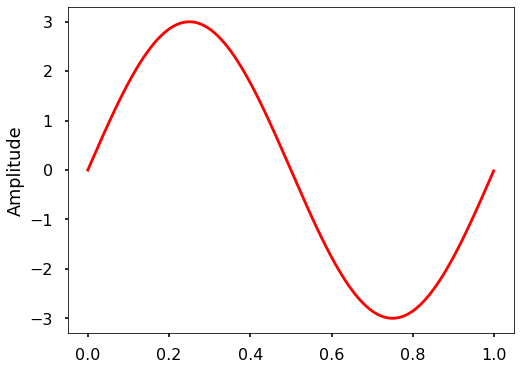

N =  1024
n =  [   0    1    2 ... 1021 1022 1023]
T =  1.0
freq =  [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]


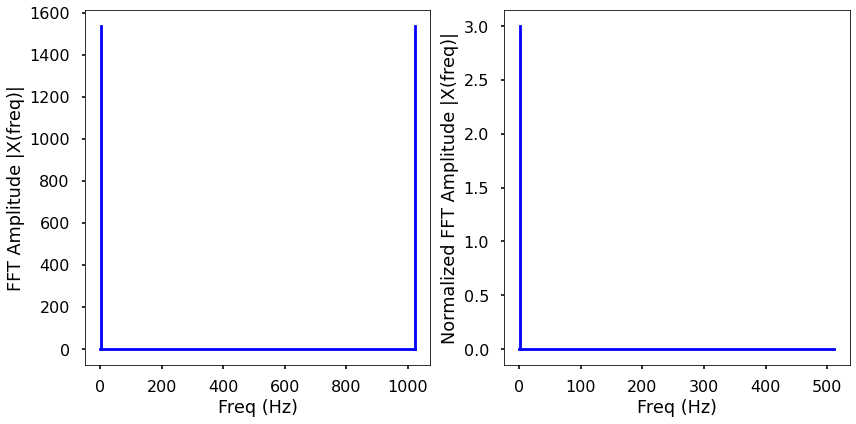

In [32]:
def generate_signal(sr):
    '''
    function to generate
    a simple 1D signal with
    different sampling rate
    '''
    ts = 1.0/sr
    t = np.arange(0,1,ts)

    freq = 1.
    x = 3*np.sin(2*np.pi*freq*t)
    return x, t


# csinálunk egy függvényt
sampling_rate = 1024

x, t = generate_signal(sampling_rate)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')
plt.show()

# megnézzük az fft
X = FFT(x)

# kiszámoljuk a freqvenciáját
N = len(X)
print('N = ', N)
n = np.arange(N)
print('n = ', n)
T = N/sampling_rate
print('T = ', T)
freq = n/T
print('freq = ', freq)

# plot
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)'); plt.ylabel('FFT Amplitude |X(freq)|')

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)'); plt.ylabel('Normalized FFT Amplitude |X(freq)|')
plt.tight_layout()
plt.show()

# DFT

Az FT sinus és cosinus hullámokra bontaj az eredeti függvényt, ezáltál vizsgálható azok freqvenciája, amplitudója, fázisa. Az FT alkalmazható folytonos és diszkrét hullámokra is. Ebben a részben csak a diszkrét esetekről lesz szó.

A fenti signált több sinus görbéből állítottuk elő, és mindegyik különböző hosszú. Az alábbi 3Dimenziós ábra mutatatj a DFT mögötti elgondolást. Hogy több különálló sinus hullámra bondjuk az eredetit. Az egyes oszlopok magassága a signál amplitudójával arányos. A 3 függőleges oszlop egyenként 3 különböző frekvenciájú sinus hullámot jelöl.


<img src="https://pythonnumericalmethods.berkeley.edu/_images/24.02.02-time_frequency.png" height="400" width="400"/>


$$
X_k = \sum_{n=0}^{N-1}x_n \cdot e^{-i2\pi kn/N} = \sum_{n=0}^{N-1}x_n(cos(2\pi kn/N)-i \cdot sin(2 {\pi} kn/N))
$$


$N$ = number of samples

$n$ = current sample

$k$ = current frequency, where $k \in [0, N-1]$

$x_n$ = the sine value at sample n

$X_k$ = The DFT which include information of both amplitude and phase

A fenti számítás egyébként ebből a formulából adódik:

$$
e^{i \cdot x} = \cos x + i \cdot sin x
$$

Megjegyzendő, hogy $X_k$ egy komplex szám amely tartalmazza mind az amplitudó, mind a fázis információit a complex sinus componensnek $e^{i \cdot 2 \pi kn/N}$
minden $x_n$-re

Az amplitudó és a fázis kiszámítása valahogy így történik.:

$$
amp = \frac{|X_k|}{N} = \frac{\sqrt{Re(X_k)^2 + Im(X_k)^2}}{N}
$$

$$
phase = atan2(Im(X_k), Re(X_k))
$$

Ahol Im és Re az imaginárius és a valós számok és argumentumai az $arctan$ függvénynek.

Csinálok három sinus görbét 1 Hz, 4 Hz és 7Hz, amplitúdójuk legyen 3, 1, 0.5 és a fázis mindhárom esetben 0. Összeadom ezt a három görbét 100 Hz mintavételezés mellett.

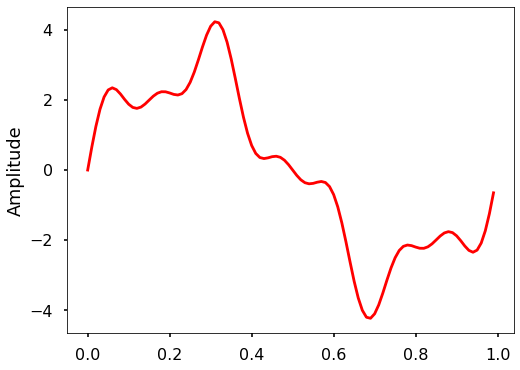

In [34]:

# --------------------------------------------

# sampling rate
sampling_rate = 100
# sampling interval
ts = 1.0/sampling_rate
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += 1*np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')
plt.show()

# --------------------------------------------

A DFT(x) függvény egy argumentumot vár, egy 1 dimenziós valós számokból álló tömböt. A DFT kiszámolja x-nek a DFT értékeit.

In [36]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

# ------------------

X = DFT(x)

print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(100,)


Na ja, van egy sampling_rate-el azonos hosszú tömbünk, mit kezdjük vele.

Hát ki kéne számolni a frekvenciát, ami

X tömb hossza (100)

np.arange(100) -> ami egy tömb [1, 2, 3, ..., 99, 100]

T = 100/100

n = [1, 2, 3, .., 100]/1


```
# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sampling_rate
freq = n/T
```




In [38]:
# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sampling_rate
freq = n/T

print('N = ', N)
print('T = ', T)
print(freq)

N =  100
T =  1.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


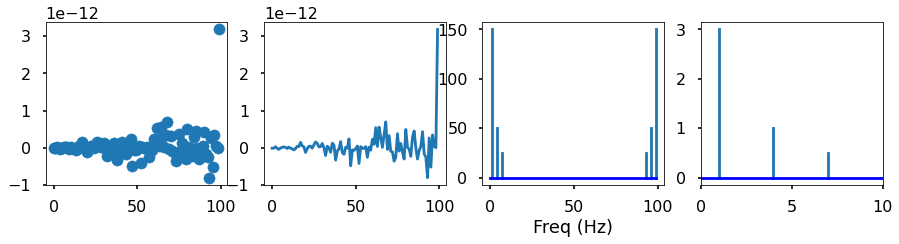

In [58]:
fig, ax = plt.subplots(1,4, figsize=(15, 3))
ax[0].scatter(freq, X)
ax[1].plot(X)
ax[2].stem(freq, abs(X), markerfmt=" ", basefmt="-b")
ax[2].set_xlabel('Freq (Hz)')
ax[3].stem(freq[:int(N/2)], abs(X[:int(N/2)]/(N/2)), markerfmt=" ", basefmt="-b")
ax[3].set_xlim(0,10)
plt.show()


Na valahogy így kell megjeleníteni a DFT eredményeket,

Az utolsó plotton normalizáltam X tömböt, vagyis elosztottam a hosszának a felével az értékeket. Az látszik, hogy 3 csúcs van, 1 Hz, 4 Hz, 7 Hz, 3, 1, 0.5 amplitúdóval.

Hát valahogy így használják a DFT-t arra, hogy egy signált sinus komponenseire bontsanak.

# Az inverse DFT

Természetesen ebből visszafelé is elő lehet állítani az eredeti signált.

# Problélma a DFT-vel

Hogy nem hatékony, ha nagyon sok adatunk van, vagy hosszú a sigál.
Ha a mintavételi ráta magas mondjuk 2000 pont, akkor már elég lassú. Természetesen az életben még magasabb mintavételi ráta is van mondjuk 44100.

# FFT (Fast Fourirer Transform)

Szerencsére ezt a problémát orvosolja az FFT. amit Cooley és Tukey 1965-ben írt le.

# A hullámokról általában

A hullám mint függvény $F(x,t)$ ahol $x$ egy pont a térben (ó) és $t$ az idő. Egy példa a sinus hullámra.

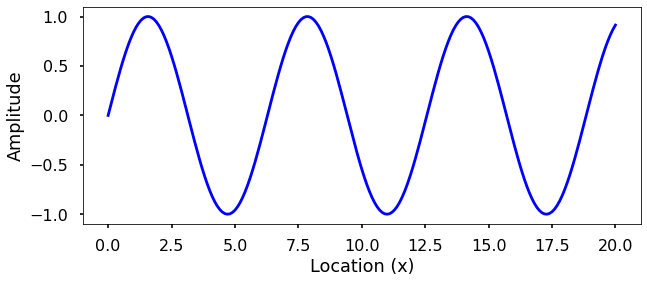

In [60]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

x = np.linspace(start = 0, stop = 20, num = 201)
y = np.sin(x)

plt.figure(figsize = (10, 4))
plt.plot(x, y, 'b')
plt.ylabel('Amplitude')
plt.xlabel('Location (x)')
plt.show()

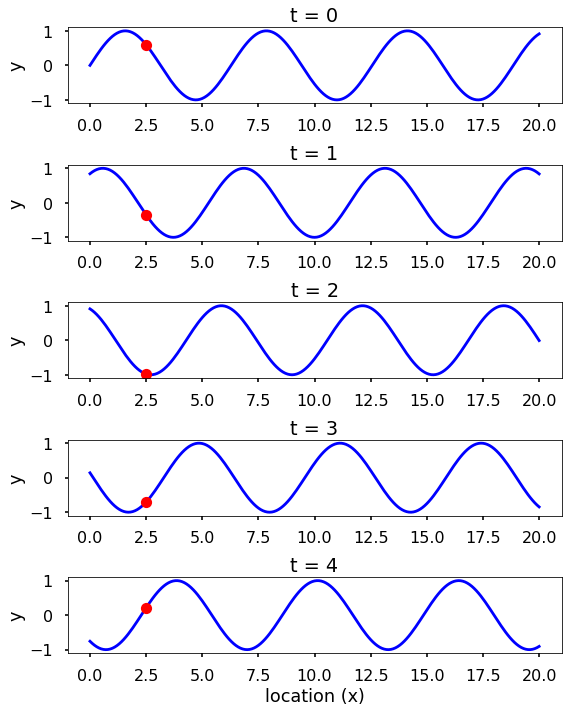

In [63]:
fig = plt.figure(figsize = (8,10))

times = np.arange(5)

n = len(times)

for t in times:
    plt.subplot(n, 1, t+1)
    y = np.sin(x + t)
    plt.plot(x, y, 'b')
    plt.plot(x[25], y [25], 'ro')
    plt.ylim(-1.1, 1.1)
    plt.ylabel('y')
    plt.title(f't = {t}')

plt.xlabel('location (x)')
plt.tight_layout()
plt.show()


Szóval a hullám lehet időben és térben is folytonos. De a valóságban inkább az a helyzete, hogy ezek diszkrét értékekek. Például egy adott idő alatt 44100 szor megmérjük a az értékét.

<img src="https://pythonnumericalmethods.berkeley.edu/_images/24.01.01-period_amplitude.jpg" />

<img src="https://pythonnumericalmethods.berkeley.edu/_images/24.01.02-wavelength_amplitude.jpg" />

Szóval ha az idő függvényében nézzük akkor periódusról beszélünk, ha viszont térben mérjük, akkor hullámhosszról.

Az amplitudója a középértéktől mért maximum.

Periodusról akkor beszélünk, ha a hullám ismétli önmagát. A sinus hullám egy periodikus hullám, mert bizonyos időközönként, vagy adott időközönként ismétli önmagát. Egy hullám periódusa egy komplett ciklus.

A **Frekvencia** azt írja le, hogy adott idő alatt hány hullám periodus fordult elő. Általában másodperc alatt, mértékegysége a Herz. Tehát 50 herz azt jelenti, hogy egy másodperc alatt 50 ciklus ment le. A frekvencia nem azonos a periódussal, de kapcsolatban vannak egymással.

$$
period = \frac{1}{frequency}
$$

A mérések gyakoriságát - mintavételezési rátának hívják - és szintén herzben mérik. Például ha a mintavételezési ráta 2 Herz akkor az azt jelenti, hogy másodpercenkét 2 mérést végzünk (ezért például az audio fájloknál a mintavételezési ráta 44100 Herz, ennyiszer mérünk másodpercenként)

Szóval a szinusz hullám felirható így is:

$$
y(t) = A \cdot sin(\omega t  + \phi)
$$

$A$ az amplitudója a hullámnak. $\omega$ az **angular frekvencia** amely azt jelzi, hogy hány ciklus fordul elő egy másodperc alatt radiánsban. $\phi$ a signál fázisa.

Ha $T$ a periodusa egy hullámnak és $f$ a frekvenciája akkor $\omega$ ez az angular frekvencia felírható így:

$$
\omega = \frac{2\pi}{T} = 2\pi f
$$

Csináljunk két szinusz hllámot 0 és 1 másodperc között 5 és 10 Herzeset és összesen 100 mérési ponttal, tehát 100 Herczes mintavételezésel.

Rajzoljuk ki a két hullámot, figyeljük meg a különbséget és számoljuk meg, hány ciklus van egy másodperc alatt.


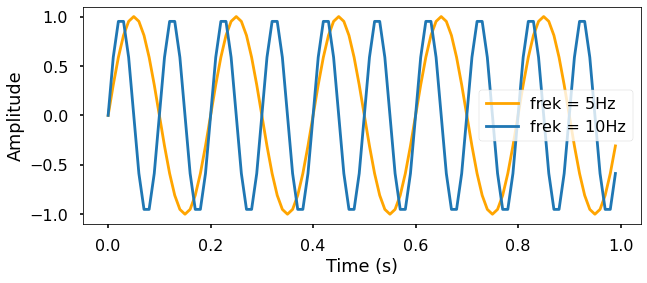

In [68]:
# sampling rate
sampling_rate = 100.0
# sampling interval
ts = 1.0/sampling_rate
t = np.arange(0,1,ts)

# frequency of the signal
freq = 5   
y = np.sin(2*np.pi*freq*t)

plt.figure(figsize = (10, 4))
plt.plot(t, y, 'orange', label='frek = 5Hz')


freq = 10   
y = np.sin(2*np.pi*freq*t)

plt.plot(t, y, label='frek = 10Hz')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


Csináljunk két szinusz hullámot 0 és 1 másodperc között. Mindkét hullám frekvenciája legyen 5 Hz és 100 Hz mintavételezéssel. De az egyik fázisa legyen 0 a másik 10. Nézzük meg a különbséget.

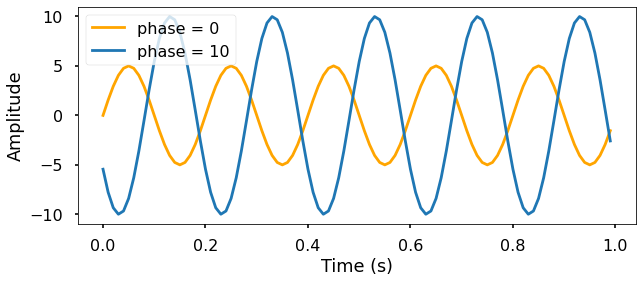

In [69]:
# frequency of the signal
freq = 5   
y = 5*np.sin(2*np.pi*freq*t)

plt.figure(figsize = (10, 4))

plt.plot(t, y, 'orange', label='phase = 0')

y = 10*np.sin(2*np.pi*freq*t + 10)

plt.plot(t, y, label='phase = 10')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.legend()
plt.show()